# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# Import Dataset

## 📦 Dataset Description

The dataset used in this project is sourced from Kaggle: [Flight Price Prediction Dataset](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data). Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities. 

There are three CSV files provided:

- `business.csv`: Contains flight records for business class tickets.
- `economy.csv`: Contains flight records for economy class tickets.
- `clean_dataset.csv`: A combined and cleaned dataset that includes both business and economy class records with standardized features and formatting.

Each record in the dataset includes the following key features:
1) Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.
2) Flight: Flight stores information regarding the plane's flight code. It is a categorical feature.
3) Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.
4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
5) Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
7) Destination City: City where the flight will land. It is a categorical feature having 6 unique cities.
8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
10) Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
11) Price: Target variable stores information of the ticket price.

In [2]:
clean_df = pd.read_csv('Clean_Dataset.csv')
business_df = pd.read_csv('business.csv')
economy_df = pd.read_csv('economy.csv')

In [3]:
clean_df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
business_df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"


In [5]:
economy_df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


For this project, I chose to use the `clean_dataset.csv` file

# Exploratory Data Analysis (EDA) and Preprocessing Data

## 📊 Exploratory Data Analysis (EDA)

In [6]:
df = clean_df.copy()

In [7]:
df.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [9]:
df.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df['source_city'].unique()

array(['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai'],
      dtype=object)

In [12]:
df['destination_city'].unique()

array(['Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai', 'Delhi'],
      dtype=object)

### Distribution of Flight Prices per Airline

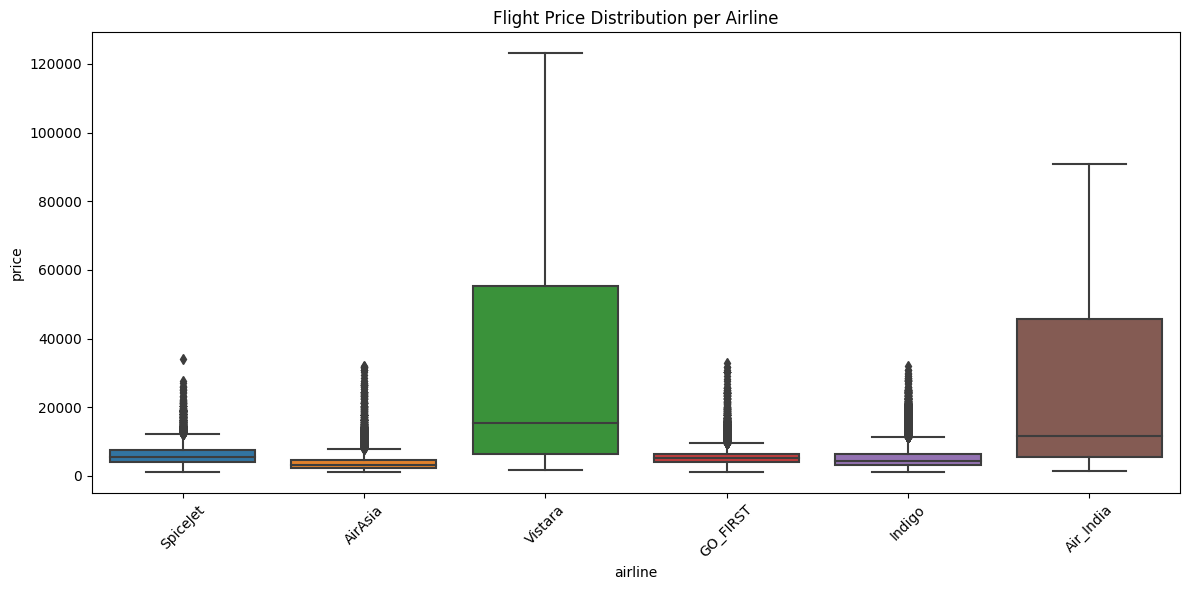

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='airline', y='price')
plt.xticks(rotation=45)
plt.title('Flight Price Distribution per Airline')
plt.ylabel('price')
plt.xlabel('airline')
plt.tight_layout()
plt.show()

### Average Price Based on Total Stops

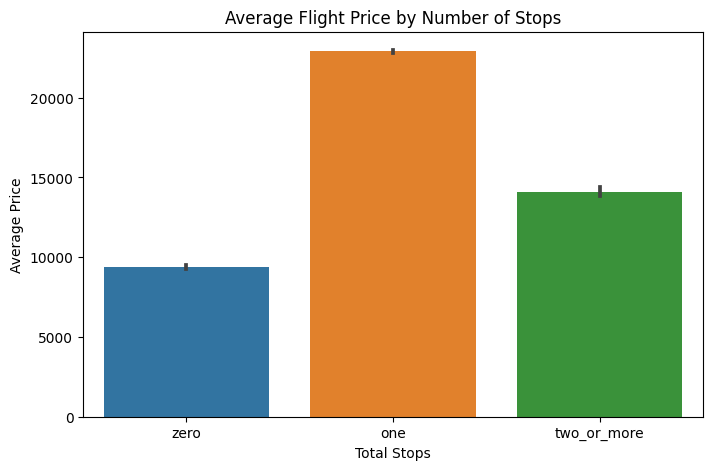

In [14]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='stops', y='price', estimator='mean')
plt.title('Average Flight Price by Number of Stops')
plt.xlabel('Total Stops')
plt.ylabel('Average Price')
plt.show()

###  Price Comparison: Economy vs Business Class

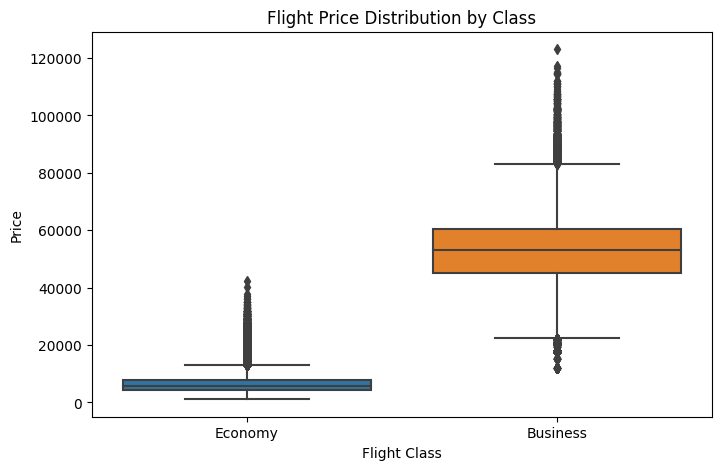

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='class', y='price')
plt.title('Flight Price Distribution by Class')
plt.xlabel('Flight Class')
plt.ylabel('Price')
plt.show()

### Price Distribution

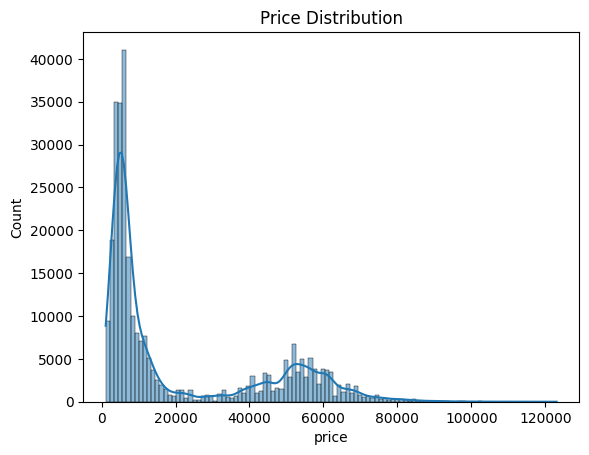

In [16]:
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.show()

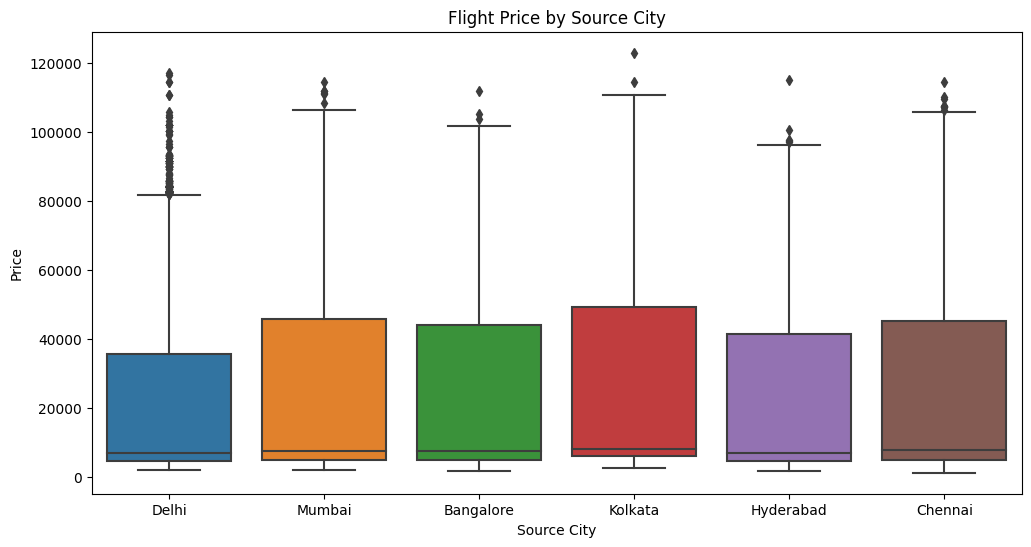

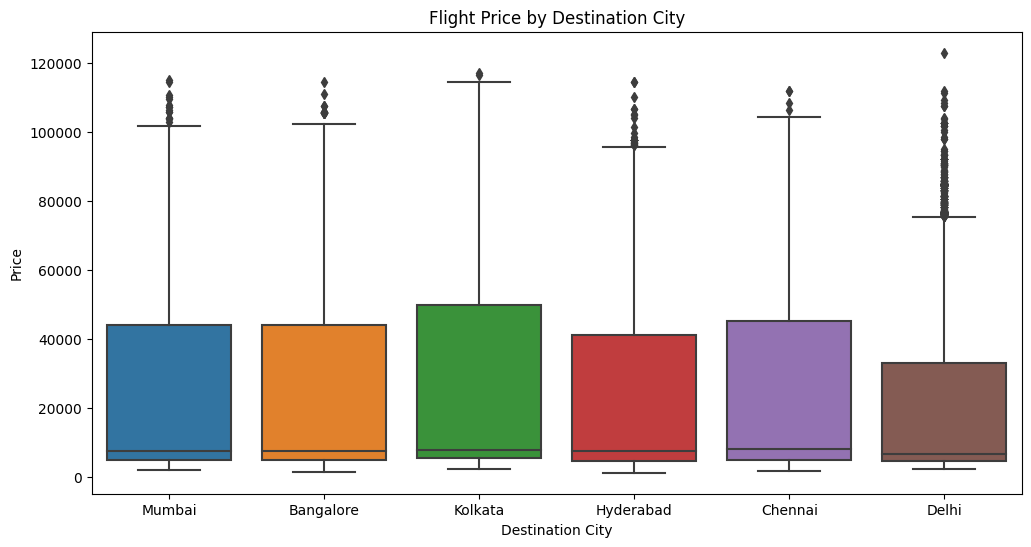

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='source_city', y='price')
plt.title('Flight Price by Source City')
plt.xlabel('Source City')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='destination_city', y='price')
plt.title('Flight Price by Destination City')
plt.xlabel('Destination City')
plt.ylabel('Price')
plt.show()

### Correlation Matrix

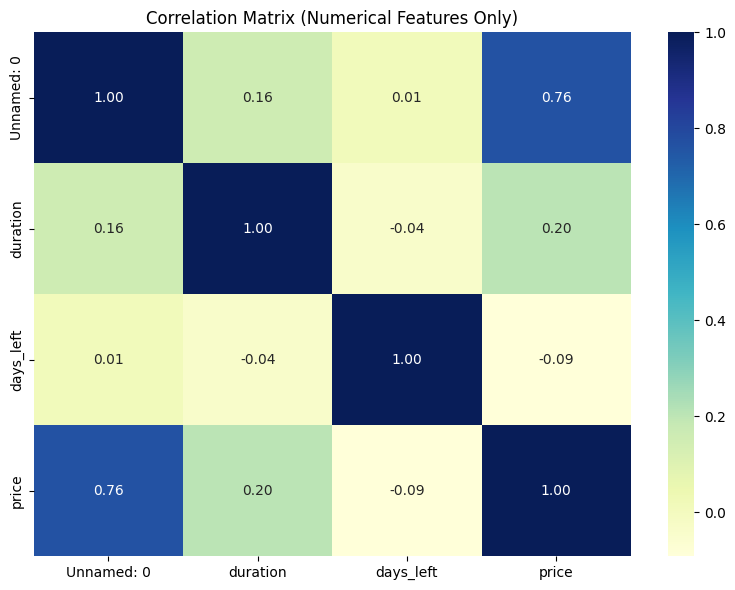

In [18]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_numeric = numeric_df.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_numeric, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix (Numerical Features Only)')
plt.tight_layout()
plt.show()

## Preprocessing Data

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [20]:
df.rename(columns={'class': 'travel_class'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   travel_class      300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [21]:
# delete/drop column 'Unnamed: 0 '
df.drop(columns=['Unnamed: 0'], inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   travel_class      300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [23]:
df['price'] = df['price'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   travel_class      300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 25.2+ MB


In [24]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,travel_class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953.0
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953.0
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956.0
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955.0
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955.0


In [25]:
df['flight'].unique().tolist()

['SG-8709',
 'SG-8157',
 'I5-764',
 'UK-995',
 'UK-963',
 'UK-945',
 'UK-927',
 'UK-951',
 'G8-334',
 'G8-336',
 'G8-392',
 'G8-338',
 '6E-5001',
 '6E-6202',
 '6E-549',
 '6E-6278',
 'AI-887',
 'AI-665',
 'I5-747',
 'G8-266',
 'G8-101',
 'G8-103',
 'AI-441',
 '6E-5328',
 'UK-933',
 '6E-2046',
 'I5-744',
 'SG-8169',
 '6E-5041',
 'G8-165',
 '6E-2373',
 'UK-813',
 'UK-817',
 'UK-819',
 'UK-801',
 'UK-815',
 'AI-453',
 'SG-2976',
 'AI-504',
 'AI-502',
 'AI-506',
 'AI-803',
 'AI-479',
 'SG-339',
 'UK-955',
 'UK-627',
 'I5-784',
 'AI-9643',
 'AI-540',
 'AI-429',
 'AI-439',
 'AI-9645',
 '6E-2193',
 '6E-2168',
 '6E-152',
 '6E-369',
 'UK-899',
 'AI-764',
 'UK-747',
 'UK-809',
 'UK-737',
 '6E-2338',
 'G8-237',
 'UK-871',
 'AI-762',
 'G8-1404',
 'AI-512',
 'AI-537',
 'UK-977',
 '6E-184',
 'SG-3002',
 '6E-2102',
 'AI-801',
 'UK-637',
 'UK-835',
 'AI-531',
 'UK-705',
 'UK-707',
 'UK-673',
 'AI-839',
 'UK-879',
 'G8-191',
 'AI-767',
 'AI-401',
 'AI-473',
 'G8-213',
 'AI-409',
 'UK-837',
 'AI-877',
 '

In [26]:
len(df['flight'].unique().tolist())

1561

In [28]:
categorical_cols = ['airline', 'flight', 'source_city', 'departure_time',
                    'stops', 'arrival_time', 'destination_city', 'travel_class']

encoders = {}

# Label Encoding
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  

# save into file .pkl
with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(encoders, file)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  int64  
 1   flight            300153 non-null  int64  
 2   source_city       300153 non-null  int64  
 3   departure_time    300153 non-null  int64  
 4   stops             300153 non-null  int64  
 5   arrival_time      300153 non-null  int64  
 6   destination_city  300153 non-null  int64  
 7   travel_class      300153 non-null  int64  
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  float64
dtypes: float64(2), int64(9)
memory usage: 25.2 MB


In [30]:
df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,travel_class,duration,days_left,price
0,4,1408,2,2,2,5,5,1,2.17,1,5953.0
1,4,1387,2,1,2,4,5,1,2.33,1,5953.0
2,0,1213,2,1,2,1,5,1,2.17,1,5956.0
3,5,1559,2,4,2,0,5,1,2.25,1,5955.0
4,5,1549,2,4,2,4,5,1,2.33,1,5955.0
...,...,...,...,...,...,...,...,...,...,...,...
300148,5,1477,1,4,0,2,3,0,10.08,49,69265.0
300149,5,1481,1,0,0,5,3,0,10.42,49,77105.0
300150,5,1486,1,1,0,5,3,0,13.83,49,79099.0
300151,5,1483,1,1,0,2,3,0,10.00,49,81585.0


In [31]:
def normalization(df):
    X = df.drop(['price'], axis=1)  
    y = df['price'] 
    
    # Create scalers for features and target
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    # Scale the features
    X_scaled = scaler_features.fit_transform(X)
    
    # Scale the target variable
    y_scaled = scaler_target.fit_transform(y)
    
    # Save the scalers to files
    joblib.dump(scaler_features, 'scaler_features.pkl')
    joblib.dump(scaler_target, 'scaler_target.pkl')
    
    # Convert scaled data back to DataFrames
    features_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    target_scaled_df = pd.DataFrame(y_scaled, columns=['price'])
    
    # Combine the scaled features and target into a single DataFrame
    df_scaled = pd.concat([features_scaled_df, target_scaled_df], axis=1)
    
    return df_scaled

In [32]:
X = df.drop(['price'], axis=1)  
y = df[['price']] 

scaler_features = StandardScaler()
scaler_target = StandardScaler()

# scale the features
X_scaled = scaler_features.fit_transform(X)

# scale target
y_scaled = scaler_target.fit_transform(y)

# save
with open('scaler_target.pkl', 'wb') as f:
    pickle.dump(scaler_target, f)

with open('scaler_features.pkl', 'wb') as f:
    pickle.dump(scaler_features, f)

features_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
target_scaled_df = pd.DataFrame(y_scaled, columns=['price'])

df_scaled = pd.concat([features_scaled_df, target_scaled_df], axis=1)

In [33]:
df_scaled

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,travel_class,duration,days_left,price
0,0.488270,0.749163,-0.329721,-0.237897,2.577006,1.105790,1.382425,0.672576,-1.397531,-1.843875,-0.658068
1,0.488270,0.699947,-0.329721,-0.807934,2.577006,0.531627,1.382425,0.672576,-1.375284,-1.843875,-0.658068
2,-1.693633,0.292161,-0.329721,-0.807934,2.577006,-1.190865,1.382425,0.672576,-1.397531,-1.843875,-0.657936
3,1.033746,1.103046,-0.329721,0.902176,2.577006,-1.765028,1.382425,0.672576,-1.386407,-1.843875,-0.657980
4,1.033746,1.079610,-0.329721,0.902176,2.577006,0.531627,1.382425,0.672576,-1.375284,-1.843875,-0.657980
...,...,...,...,...,...,...,...,...,...,...,...
300148,1.033746,0.910871,-0.900576,0.902176,-0.426792,-0.616701,0.235992,-1.486822,-0.297695,1.695692,2.131285
300149,1.033746,0.920246,-0.900576,-1.377971,-0.426792,1.105790,0.235992,-1.486822,-0.250421,1.695692,2.476694
300150,1.033746,0.931964,-0.900576,-0.807934,-0.426792,1.105790,0.235992,-1.486822,0.223718,1.695692,2.564545
300151,1.033746,0.924933,-0.900576,-0.807934,-0.426792,-0.616701,0.235992,-1.486822,-0.308819,1.695692,2.674071


In [34]:
X = df_scaled.drop(['price'], axis=1)  # features
y = df_scaled['price'] 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

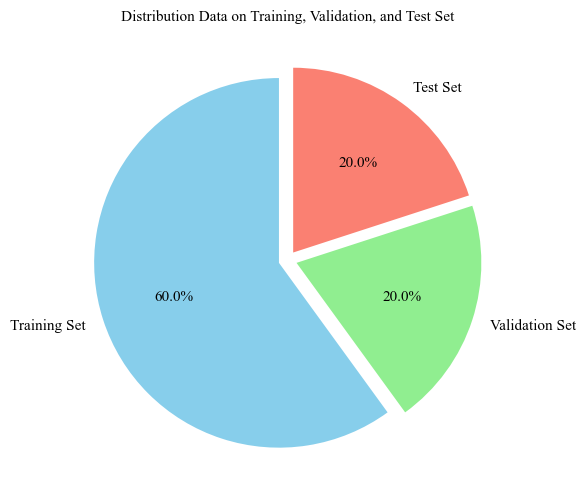

In [37]:
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Training Set', 'Validation Set', 'Test Set']
colors = ['skyblue', 'lightgreen', 'salmon']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.05, 0.05, 0.05), textprops={'fontname':'Times New Roman', 'fontsize': 11})
plt.title('Distribution Data on Training, Validation, and Test Set', fontname='Times New Roman', fontsize=11)
plt.show()

In [38]:
rf = RandomForestRegressor(random_state=42)

In [39]:
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5, 7],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # jumlah kombinasi parameter yang diuji
    cv=3,       # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [40]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  30.8s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  30.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  30.3s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=7, min_samples_split=2, n_estimators=400; total time= 1.1min
[CV] END max_depth=40, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

[CV] END max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=400; total time= 1.8min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=  51.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time= 1.8min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=400; total time= 1.8min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  46.0s
[CV] END max_depth=40, max_features=sq

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 5, 7],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [41]:
best_model_rf = random_search.best_estimator_

In [42]:
# predict in training and validation set
y_train_pred = best_model_rf.predict(X_train)
y_val_pred = best_model_rf.predict(X_val)

In [43]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# MSE
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)

# MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

# Print the result
print("\n=== Evaluation Metrics ===")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")


=== Evaluation Metrics ===
Train RMSE: 0.0672
Validation RMSE: 0.1097
Train MSE: 0.0045
Validation MSE: 0.0120
Train MAE: 0.0280
Validation MAE: 0.0468


In [44]:
joblib.dump(best_model_rf, 'best_model_rf.pkl')

['best_model_rf.pkl']

[CV] END max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=  43.6s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time= 1.8min
[CV] END max_depth=30, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time= 3.8min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.0min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time= 1.9min
[CV] END max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=  43.7s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=40, max_features=

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  float64
 1   flight            300153 non-null  float64
 2   source_city       300153 non-null  float64
 3   departure_time    300153 non-null  float64
 4   stops             300153 non-null  float64
 5   arrival_time      300153 non-null  float64
 6   destination_city  300153 non-null  float64
 7   travel_class      300153 non-null  float64
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  float64
dtypes: float64(10)
memory usage: 22.9 MB
[CV] END max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=  40.5s
[CV] END max_depth=30, max_feat